In [82]:
import pandas as pd
import numpy as np
#import keras 
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import log_loss, accuracy_score
import pymc3
from scipy import stats
np.random.seed = 42
from IPython.display import Image
from IPython.core.display import HTML

### Learning to Simulate

Simplified implementation of paper below.

Simplifications, ditch RIENFORCE to just act on accuracy vector ( Y_true - y_pred)

**Paper:** https://arxiv.org/pdf/1810.02513.pdf

**Resources for RIENFORCE algorithms:** 
1. https://medium.com/samkirkiles/reinforce-policy-gradients-from-scratch-in-numpy-6a09ae0dfe12
<br>
<br>
2. http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf


## See page 3 for psudo-code

1. Use policy $\pi_{\omega}$ to generate $K$ model parameters $\Psi_{k}$
2. Generate $K$ datasets of size M (simplified)
3. Train Main task (MTM) model on $K$ datasets
4. Calculate the accuracy of the trained MTM on the validation set.
5. Compute the advantage estimate (We will skip this step)
6. Update policy parameters, $\omega$    

### Create our simple validation Dataset


In [12]:
### Validation Data -

X_true = np.array([[1,2],
                  [1.2,2],
                  [1.5,2],
                  [2.2, 1],
                  [2.3, 1],
                  [2.4, 1]])
                                
Y_true = np.array([1,1,1,0,0,0])

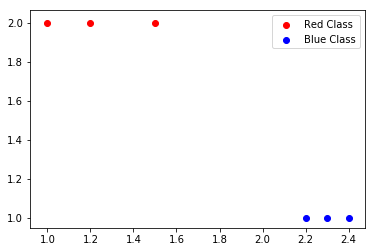

In [13]:
### Plot of our Validation Data
plt.scatter(X_true[:3,0], X_true[:3,1], c='r', label='Red Class')
plt.scatter(X_true[3:,0], X_true[3:,1], c='b', label='Blue Class')
plt.legend(loc='best');

### In the plot above we can imagine a linear decision boundary

### Assumption - we know how many classes we want

### Simulator

In [7]:
# Bounds - we want to give our simulator a space we expect the data to come from
#BOUNDS = [-1,4] # sim data values should fall between -1 and 4, inclusive

SIM_DATA_COUNT = 10 # number of observations per class we want to generate


The paper used GMM as an example, we can simplify by just using 
samples from gaussians to generate our (x,y) cord. pairs.

We will hold our standard deviations fixed and only update our
$\mu$ values each epoch <br>

<br>
NOTE:
<br>
loc = $\mu$, mean <br>
scale = $\sigma$, standard deviation

In [14]:
red = np.random.normal(loc=1, scale=0.1, size=SIM_DATA_COUNT) 
red1 = np.random.normal(loc=1, scale=0.1, size=SIM_DATA_COUNT) 
red_array = np.array([red, red1]).T

In [15]:
blue = np.random.normal(loc=1, scale=0.1, size=SIM_DATA_COUNT)
blue1 = np.random.normal(loc=1, scale=0.1, size=SIM_DATA_COUNT)
blue_array = np.array([blue, blue1]).T

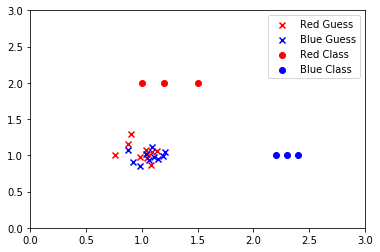

In [16]:
plt.scatter(red_array[:,0], red_array[:,1], marker='x', c='red', label='Red Guess')
plt.scatter(blue_array[:,0], blue_array[:,1], marker='x', c='blue', label='Blue Guess')
plt.scatter(X_true[:3,0], X_true[:3,1], c='r', label='Red Class')
plt.scatter(X_true[3:,0], X_true[3:,1], c='b', label='Blue Class')
plt.xlim(0, 3)
plt.ylim(0,3)
plt.legend(loc='best');

### What do we see?

In the plot above we would expect our guesses to be clustered together, 
becuase they are generated by the same $\mu$ and $\sigma$ parameters.
As we simulate new data, fit and test we can then update the $\mu$ to yield a distribution that more closely matches the validation data.
<br>


### Simulator

This function will take the paramaters of our distributions 
and an integer for the number of samples we want to take.
<br>
<br>
Then, we will assign labels based on the distribtion that generated the values.
<br>
<br>
Finally, an array of the (x,y) cords. and class label are returned. Where 1 = red and 0 = blue

In [24]:
def SIMULATOR(red_mu=0, red_sd=0.1,
              blue_mu=0, blue_sd=0.1, 
              SIM_DATA_COUNT=10):
    
    # Red Class - sample values from gaussian
    red = np.random.normal(loc=red_mu, scale=red_sd, size=SIM_DATA_COUNT) 
    red1 = np.random.normal(loc=red_mu, scale=red_sd, size=SIM_DATA_COUNT) 
    red_array = np.array([red, red1]).T
    
   # Blue Class - sample values from gaussian 
    blue = np.random.normal(loc=blue_mu, scale=blue_sd, size=SIM_DATA_COUNT)
    blue1 = np.random.normal(loc=blue_mu, scale=blue_sd, size=SIM_DATA_COUNT)
    blue_array = np.array([blue, blue1]).T

    # Assign class label, 1 = red, 0 = blue    
    red_set = np.vstack([red_array.T, np.ones_like(red)]).T
    blue_set = np.vstack([blue_array.T, np.zeros_like(blue)]).T

    # combine the simulated sets
    sim_train_data = np.concatenate((red_set, blue_set))

    return sim_train_data


### Fit and test

This function takes:
    * A classifier (SVM with RBF kernel in this case)
    * simulated data array
    * Validation data

1. The classifier is fit with the simulated data
2. Simple error is calculated 
3. the simple error is returned

In [25]:
def fit_and_test(clf, sim_train_data, X_true, Y_true):
    
    # prepare simulated data
    X = sim_train_data[:,:2]
    Y = sim_train_data[:,-1]
    
    # Train on simulated data
    clf.fit(X,Y)
    
    # predict
    pred = clf.predict(X_true)
    
    # simple error  - accuracy
    acc = Y_true - pred
    
    return acc

### Calculate Adjustment Step

I started to dig into the RIENFORCE algorithm and some awesome policy gradient stuff,
but it was quickly obvious that I would need a while to digest it.

So, rather than dealing with gradients we can just use the accuracy vector!


This function takes:
    * an accuracy vector
    * the class labels from the validation set
    * A learning rate - the amount we will adjust the *_mu value per epoch

The class label vector is used to get the indecies that corespond to the accuracy value
<br>
The adjustment factor for each datum is the absolute value of the accuracy value * learing rate.
<br> 
To simplify, the mode of the adjustments per class is taken to get a single scaler for each class.
<br>
The Scalers are returned so that they can be applied in a future update step.

In [26]:
### Rather than dealing with gradients we can just use the accuracy column
# lr = learning rate = the amount we will adjust the *_mu value

def mu_adj(acc, Y_true, lr=0.2):
    
    # Get class 1 indecies
    c1_id = [i for i in range(len(Y_true)) if Y_true[i] > 0]
    #Getclass 2 idecies
    c0_id = [i for i in range(len(Y_true)) if Y_true[i] == 0]
    
    adj =  abs(acc * lr) # multiply by -1 because accuracy of -1 means we need to INCREASE mu, so we want a postive value
    
    # For class `1` 
    class_1_adj = stats.mode(adj[[c1_id]])[0][0] # take the mode of the adjustments
    
    class_0_adj = stats.mode(adj[[c0_id]])[0][0] # take the mode of the adjustments
    
    return [class_1_adj, class_0_adj]

### Put it all together

**Psudo code** <br>
1. Use policy $\pi_{\omega}$ to generate $K$ model parameters $\Psi_{k}$
2. Generate $K$ datasets of size M (simplified)
3. Train Main task (MTM) model on $K$ datasets
4. Calculate the accuracy of the trained MTM on the validation set.
5. Compute the advantage estimate (We will skip this step)
6. Update policy parameters, $\omega$    


### DISCLAIMER: SINCE WE'RE DEALING WITH RANDOM NUMBERS YOU MAY NOT GET THE SAME VALUES IF YOU RERUN THIS CELL

In [59]:
clf = SVC(kernel='rbf',random_state=0, C=1000)

In [40]:
clf = SVC(kernel='rbf',random_state=0, C=1000)

LEARNING_RATE = 0.2 #how much we will adjust the *_mu values

# initialize *_mu
red_mu = 1.
blue_mu = 1.

EPOCHS = 5

for i in range(EPOCHS):
    
    epoch = i
    
    # 1., 2. Generate training data
    sim_train_data = SIMULATOR(red_mu=red_mu,
                               blue_mu=blue_mu)
    
    # 3. Train the model on sim data and evaluate accuracy
    accuracy = fit_and_test(clf, sim_train_data, X_true, Y_true)
    
    # 4. Calulate the adjustment to the *_mu values
    adjustments = mu_adj(accuracy, Y_true, lr=LEARNING_RATE)
    
    # 5. SKIP
    
    # 6. Update Policy Parameters, \omega
    red_mu += adjustments[0]
    blue_mu += adjustments[1]
    
    print(f'Finished Epoch: {epoch}')
    print(f'red_mu: {red_mu}, blue_mu: {blue_mu}')


Finished Epoch: 0
red_mu: 1.2, blue_mu: 1.0
Finished Epoch: 1
red_mu: 1.2, blue_mu: 1.2
Finished Epoch: 2
red_mu: 1.2, blue_mu: 1.4
Finished Epoch: 3
red_mu: 1.4, blue_mu: 1.4
Finished Epoch: 4
red_mu: 1.5999999999999999, blue_mu: 1.4


### hmmm... Now what?


1. Lets use the new *_mu values to generate some data
2. We will fit the model with the generated data
3. Then we will make a prediction with the validation, X_true data
4. Compare the predictions with Y_true


#### Lets see how we did

NOTE: This is a sort of cherry picked example, with the same mu values you can get samples that dont preform as well. We only have 10 samples, can always increase. In the paper they draw many datasets for each epoch.

In [65]:
# 1. Lets use the new *_mu values to generate some data
sim_train_data = SIMULATOR(red_mu=1.59,
                               blue_mu=1.4)

In [66]:
sim_train_data 

array([[ 1.64679471,  1.54947011,  1.        ],
       [ 1.64852349,  1.78497392,  1.        ],
       [ 1.38704427,  1.5772035 ,  1.        ],
       [ 1.7048872 ,  1.6325787 ,  1.        ],
       [ 1.6979524 ,  1.61300557,  1.        ],
       [ 1.72577888,  1.56998623,  1.        ],
       [ 1.63948546,  1.64343983,  1.        ],
       [ 1.76864163,  1.75177902,  1.        ],
       [ 1.65922935,  1.539877  ,  1.        ],
       [ 1.69717883,  1.63577204,  1.        ],
       [ 1.50972276,  1.3324451 ,  0.        ],
       [ 1.33803068,  1.42336062,  0.        ],
       [ 1.30552552,  1.39851441,  0.        ],
       [ 1.30256091,  1.35000444,  0.        ],
       [ 1.45535498,  1.51901994,  0.        ],
       [ 1.23886334,  1.44443158,  0.        ],
       [ 1.46719492,  1.41637137,  0.        ],
       [ 1.56330235,  1.44002004,  0.        ],
       [ 1.21442467,  1.33556802,  0.        ],
       [ 1.62000081,  1.39097868,  0.        ]])

### Quick plot - Sanity Check

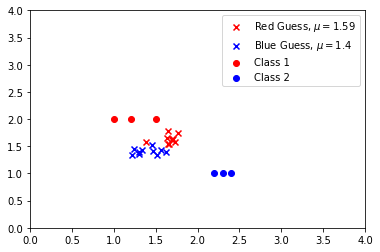

In [67]:
plt.scatter(sim_train_data[:10,0], sim_train_data[:10,1], marker='x', c='red', label='Red Guess, $\mu = 1.59$')
plt.scatter(sim_train_data[10:,0], sim_train_data[10:,1], marker='x', c='blue', label='Blue Guess, $\mu = 1.4$')
plt.scatter(X_true[:3,0], X_true[:3,1], c='r', label='Class 1')
plt.scatter(X_true[3:,0], X_true[3:,1], c='b', label='Class 2')
plt.xlim(0, 4)
plt.ylim(0,4)
plt.legend(loc='best');

In [68]:
# Prepare simulated data
X = sim_train_data[:,:2]
Y = sim_train_data[:,-1]


In [69]:
# 2. Fit the model with simulated Data
clf.fit(X, Y)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
# 3. Then we will make a prediction with the validation, X_true data
pred = clf.predict(X_true)

In [71]:
pred

array([ 1.,  1.,  1.,  0.,  0.,  0.])

In [72]:
Y_true

array([1, 1, 1, 0, 0, 0])

In [73]:
accuracy_score(Y_true, pred) # Sweet!

1.0

In [ ]:
### 

In [76]:
X_true

array([[ 1. ,  2. ],
       [ 1.2,  2. ],
       [ 1.5,  2. ],
       [ 2.2,  1. ],
       [ 2.3,  1. ],
       [ 2.4,  1. ]])

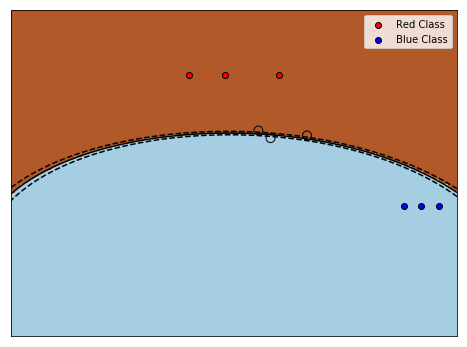

In [81]:
# figure number
fignum = 1

# plot the line, the points, and the nearest vectors to the plane
plt.figure(fignum, figsize=(8, 6))
plt.clf()

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X_true[:3, 0], X_true[:3, 1], c='red', zorder=10, edgecolors='k', label='Red Class')
plt.scatter(X_true[3:, 0], X_true[3:, 1], c='blue', zorder=10, edgecolors='k', label='Blue Class')
#plt.scatter(X[:10,0], X[:10,1], c='red', marker='x', label='Red Guess')
#plt.scatter(X[10:,0], X[10:,1], c='blue', marker='x', label='blue Guess')

plt.axis('tight')
x_min = 0
x_max = 2.5
y_min = 0
y_max = 2.5

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(fignum, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.legend(loc='best');

### Woot we did it!

### PUT MEMES HERE!

# ----------------------------------